# Systèmes de Recommandation (RecSys)


Exemple de modèle de recommandation avec pytorch et un LSTM

[REQUIREMENTS.txt](#requirements)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from urllib.request import urlretrieve
from zipfile import ZipFile

from sklearn.utils import shuffle

In [2]:
# --- télécharger les données
chemin, _ = urlretrieve('https://files.grouplens.org/datasets/movielens/ml-20m.zip', '../tmp/ml-20m.zip')

In [3]:
# --- extraire
with ZipFile(chemin, 'r') as z:
    z.extractall(path='../tmp/')

In [4]:
df = pd.read_csv('../tmp/ml-20m/ratings.csv')

In [5]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [6]:
# Vérifier l'ordre des identifiants

users = df['userId'].copy().reset_index().drop('index', axis=1)
movies = df['movieId'].copy().reset_index().drop('index', axis=1)

users.drop_duplicates(inplace=True)
movies.drop_duplicates(inplace=True)

users.sort_values(by='userId',inplace=True)
movies.sort_values(by='movieId',inplace=True)

users['start'] = users['userId']
movies['start'] = movies['movieId']

users['end'] = users['userId'].shift(-1)
movies['end'] = movies['movieId'].shift(-1)

users['gap'] = users['userId'].shift(-1) - users['userId']
movies['gap'] = movies['movieId'].shift(-1) - movies['movieId']


In [7]:
print('size gap in users id: ', users[users['gap'] > 1].shape[0])
print()
print('size gap in movies id: ', movies[movies['gap'] > 1].shape[0])

size gap in users id:  0

size gap in movies id:  17874


In [8]:
# --- création de nouveaux ids sans gaps
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [9]:
df.tail()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
20000258,138493,68954,4.5,1258126920,138492,13754
20000259,138493,69526,4.5,1259865108,138492,13862
20000260,138493,69644,3.0,1260209457,138492,13875
20000261,138493,70286,5.0,1258126944,138492,13993
20000262,138493,71619,2.5,1255811136,138492,14277


In [10]:
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5

In [11]:
# Nombre d'utilisateurs et de films
N = len(set(user_ids))
M = len(set(movie_ids))

# Dimension du vecteur d'embeddings
D = 10

In [17]:
# Train / test data 
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

ntrain = int(0.8 * len(ratings))
train_users = user_ids[:ntrain]
train_movies = movie_ids[:ntrain]
train_ratings = ratings[:ntrain]

test_users = user_ids[ntrain:]
test_movies = movie_ids[ntrain:]
test_ratings = ratings[ntrain:]

In [13]:
class LSTM(nn.Module):
    
    def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
        '''
        Constructor for our custom rnn (lstm) model
        '''
        super(LSTM,self).__init__()
        
        self.N = n_users
        self.M = n_items
        self.D = embed_dim

        self.u_emb = nn.Embedding(self.N, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        self.dense1 = nn.Linear(2 * self.D, n_hidden)
        self.dense2 = nn.Linear( n_hidden, 1)

        self.u_emb.weight.data = nn.Parameter(torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
        self.m_emb.weight.data = nn.Parameter(torch.Tensor(np.random.randn(self.M, self.D) * 0.01))
    
    def forward(self, u, m):
        '''
        Forward pass
        '''
        u = self.u_emb(u)
        m = self.m_emb(m)

        out = torch.cat((u, m), 1)

        out = self.dense1(out)
        out = F.relu(out)
        out = self.dense2(out)
        
        return out

In [14]:
model = LSTM(n_users=N, n_items=M, embed_dim=D)

In [15]:
# --- GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda:0


LSTM(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (dense1): Linear(in_features=20, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=1, bias=True)
)

In [16]:
# --- Entraîner le modèle

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

def batch_gd(model, criterion, optimizer, train_data, test_data, epochs, batch_size=512):
    train_users, train_movies, train_ratings = train_data
    test_users, test_movies, test_ratings = test_data

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    ntrain = len(train_users)
    batches_per_epoch = int(np.ceil(ntrain/batch_size))

    for it in range(epochs):
        t0 = datetime.now()
        model.train()
        train_loss = []

        train_users, train_movies, train_ratings = shuffle(train_users, train_movies, train_ratings)

        for j in range(batches_per_epoch):
            users = train_users[j*batch_size:(j+1)*batch_size]
            movies = train_movies[j*batch_size:(j+1)*batch_size]
            targets = train_ratings[j*batch_size:(j+1)*batch_size]

            users = torch.from_numpy(users).long()
            movies = torch.from_numpy(movies).long()
            targets = torch.from_numpy(targets)

            targets = targets.view(-1, 1).float()

            users, movies, targets = users.to(device), movies.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(users, movies)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        
        train_loss = np.mean(train_loss)

        model.eval()
        test_loss = []
        for j in range(int(np.ceil(len(test_users) / batch_size))):
            users = test_users[j*batch_size:(j+1)*batch_size]
            movies = test_movies[j*batch_size:(j+1)*batch_size]
            targets = test_ratings[j*batch_size:(j+1)*batch_size]

            users = torch.from_numpy(users).long()
            movies = torch.from_numpy(movies).long()
            targets = torch.from_numpy(targets)

            targets = targets.view(-1, 1).float()

            users, movies, targets = users.to(device), movies.to(device), targets.to(device)
            outputs = model(users, movies)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        
        test_loss = np.mean(test_loss)

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'''Epoch {it+1}/{epochs}\n-----------------
        Train Loss: {train_loss:.4f}
        Test Loss: {test_loss:.4f}
        Duration: {dt}
        ''')
    return train_losses, test_losses

In [17]:
# lancer la boucle d'entraînement
train_losses, test_losses = batch_gd(
    model,
    criterion,
    optimizer,
    (train_users, train_movies, train_ratings),
    (test_users, test_movies, test_ratings),
    epochs=5
    )

Epoch 1/5
-----------------
        Train Loss: 0.7251
        Test Loss: 0.6808
        Duration: 0:02:04.661531
        
Epoch 2/5
-----------------
        Train Loss: 0.6496
        Test Loss: 0.6508
        Duration: 0:02:04.076460
        
Epoch 3/5
-----------------
        Train Loss: 0.6180
        Test Loss: 0.6417
        Duration: 0:02:04.215800
        
Epoch 4/5
-----------------
        Train Loss: 0.5984
        Test Loss: 0.6338
        Duration: 0:02:03.654572
        
Epoch 5/5
-----------------
        Train Loss: 0.5854
        Test Loss: 0.6320
        Duration: 0:02:06.435012
        


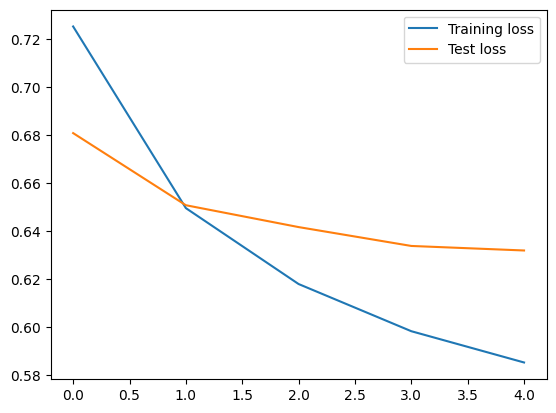

In [18]:
# Loss par itération
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

In [19]:
# Effectuer une recommandation
# 1. récupérer tous les films déjà visionnés l'utilisateur
watched_movie_ids = df[df['new_user_id'] == 1]['new_movie_id'].values

# 2. filtrer les films en retirant ceux déjà visionnés
potential_movie_ids = df[~df['new_movie_id'].isin(watched_movie_ids)]['new_movie_id'].unique()

# 3. passer l'identifiant de l'utilisateur et la liste de films non visionnés au modèle
user_id_to_recommend = np.ones_like(potential_movie_ids)

t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_movie_ids = torch.from_numpy(potential_movie_ids).long().to(device)

# prédictions
with torch.no_grad():
    preds = model(t_user_ids, t_movie_ids)

predictions = predictions = preds.cpu().numpy().flatten()

# 4. trier les recommandations par ordre descendant et recommander les 10 premières.
sort_index = np.argsort(-predictions)

top_10_movie_ids = potential_movie_ids[sort_index[:10]]
top_10_scores = predictions[sort_index[:10]]

for movie, score in zip(top_10_movie_ids, top_10_scores):
    print('recommended movie:', movie, '|', 'score:', score)

recommended movie: 1173 | score: 2.523183
recommended movie: 315 | score: 2.5147328
recommended movie: 18642 | score: 2.49552
recommended movie: 7356 | score: 2.48002
recommended movie: 843 | score: 2.4568594
recommended movie: 1263 | score: 2.410674
recommended movie: 7041 | score: 2.4106424
recommended movie: 4897 | score: 2.4065502
recommended movie: 19124 | score: 2.3953872
recommended movie: 5853 | score: 2.3878212


## <a id="requirements" style="color:black">REQUIREMENTS.txt</a>

<span style="color:orange">Ce notebook a été créé avec python 3.10</span>

Requirements.txt  

```
alembic==1.13.2
aniso8601==9.0.1
anyio==4.4.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
attrs==23.2.0
Babel==2.15.0
bcrypt==4.1.3
beautifulsoup4==4.12.3      
bleach==6.1.0
blinker==1.8.2
boto3==1.35.35
botocore==1.35.40
cachetools==5.4.0
certifi==2024.6.2
cffi==1.16.0
charset-normalizer==3.3.2   
click==8.1.7
cloudpickle==3.0.0
colorama==0.4.6
comm==0.2.2
contourpy==1.2.1
cryptography==42.0.8        
cycler==0.12.1
databricks-sdk==0.31.1      
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
Deprecated==1.2.14
docker==7.1.0
entrypoints==0.4
exceptiongroup==1.2.1
executing==2.0.1
fastjsonschema==2.19.1
filelock==3.13.1
Flask==3.0.3
fonttools==4.53.0
fqdn==1.5.1
fsspec==2024.2.0
gitdb==4.0.11
GitPython==3.1.43
google-auth==2.34.0
graphene==3.3
graphql-core==3.2.3
graphql-relay==3.2.0
greenlet==3.0.3
h11==0.14.0
httpcore==1.0.5
httpx==0.27.0
idna==3.7
imageio==2.35.1
importlib_metadata==7.1.0
intel-openmp==2021.4.0
ipykernel==6.29.4
ipython==8.25.0
ipywidgets==8.1.3
isoduration==20.11.0
itsdangerous==2.2.0
jedi==0.19.1
Jinja2==3.1.3
jmespath==1.0.1
joblib==1.4.2
json5==0.9.25
jsonpointer==3.0.0
jsonschema==4.22.0
jsonschema-specifications==2023.12.1
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-events==0.10.0
jupyter-lsp==2.2.5
jupyter_client==8.6.2
jupyter_core==5.7.2
jupyter_server==2.14.1
jupyter_server_terminals==0.5.3
jupyterlab==4.2.2
jupyterlab_pygments==0.3.0
jupyterlab_server==2.27.2
jupyterlab_widgets==3.0.11
kiwisolver==1.4.5
lazy_loader==0.4
Mako==1.3.5
Markdown==3.6
MarkupSafe==2.1.5
matplotlib==3.9.0
matplotlib-inline==0.1.7
mistune==3.0.2
mkl==2021.4.0
mlflow==2.15.1
mlflow-skinny==2.15.1
mpmath==1.3.0
nbclient==0.10.0
nbconvert==7.16.4
nbformat==5.10.4
nest-asyncio==1.6.0
networkx==3.2.1
notebook==7.2.1
notebook_shim==0.2.4
numpy==1.26.3
opentelemetry-api==1.25.0
opentelemetry-sdk==1.25.0
opentelemetry-semantic-conventions==0.46b0
overrides==7.7.0
packaging==24.1
pandas==2.2.2
pandocfilters==1.5.1
paramiko==3.4.0
parso==0.8.4
pillow==10.2.0
platformdirs==4.2.2
prometheus_client==0.20.0
prompt_toolkit==3.0.47
protobuf==5.28.2
psutil==5.9.8
pure-eval==0.2.2
pyarrow==15.0.2
pyasn1==0.6.0
pyasn1_modules==0.4.0
pycparser==2.22
Pygments==2.18.0
PyNaCl==1.5.0
pyparsing==3.1.2
pysftp==0.2.8
python-dateutil==2.9.0.post0
python-json-logger==2.0.7
pytz==2024.1
pywin32==306
pywinpty==2.0.13
PyYAML==6.0.1
pyzmq==26.0.3
qtconsole==5.5.2
QtPy==2.4.1
querystring-parser==1.2.4
referencing==0.35.1
requests==2.32.3
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rpds-py==0.18.1
rsa==4.9
s3transfer==0.10.3
scikit-image==0.24.0
scikit-learn==1.5.1
scipy==1.14.0
Send2Trash==1.8.3
six==1.16.0
smmap==5.0.1
sniffio==1.3.1
soupsieve==2.5
SQLAlchemy==2.0.31
sqlparse==0.5.1
stack-data==0.6.3
sympy==1.12
tbb==2021.11.0
terminado==0.18.1
threadpoolctl==3.5.0
tifffile==2024.9.20
tinycss2==1.3.0
tomli==2.0.1
torch==2.3.1+cu121
torchaudio==2.3.1+cu121
torchvision==0.18.1+cu121
tornado==6.4.1
traitlets==5.14.3
types-python-dateutil==2.9.0.20240316
typing_extensions==4.9.0
tzdata==2024.1
uri-template==1.3.0
urllib3==2.2.1
waitress==3.0.0
wcwidth==0.2.13
webcolors==24.6.0
webencodings==0.5.1
websocket-client==1.8.0
Werkzeug==3.0.3
widgetsnbextension==4.0.11
wrapt==1.16.0
zipp==3.19.2
```